# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", module="e3nn")
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pathlib
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import torch

from ase import Atoms
from ase.io import read
from ase.io.jsonio import encode
from ase.visualize.plot import plot_atoms

from sella import IRC

from mace.calculators import MACECalculator

from condevo.es.guidance import KNNNoveltyCondition

from cluster import load_lj_cluster, evaluate_lj_population_torch
from charlx import AtomsFixer, AtomsRelaxer, AtomsTSOptimizer, CHARLX
from condition import OriginCondition
from run import CorrectedApplyLimitsObjective, run_evo
from ase.visualize import view
from view import view_results

torch.set_default_dtype(torch.float64)

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);


def plot_atoms_without_axes(atoms, radii=None, rotation=None):
    fig, ax = plt.subplots()
    plot_atoms(atoms, ax=ax, radii=radii, rotation=rotation);
    ax.axis("off")



cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


### helper funcs

In [2]:
from ase.vibrations import Vibrations
import h5py

def check_saddle_point(atoms, eval_tol=0.1):
    """
    Quantifies saddle point quality using both mass-weighted frequencies 
    and raw Hessian eigenvalues.
    """
    # 1. Run the vibration analysis
    vib = Vibrations(atoms)
    vib.run()
    
    # 2. Vibrational Frequency Analysis (Mass-Weighted)
    freqs = vib.get_frequencies()
    # In ASE, imaginary frequencies are returned as complex numbers (e.g., 0+500j)
    imaginary_freqs = [f for f in freqs if np.iscomplex(f)]
    
    # 3. Raw Hessian Analysis (Curvature only, no mass)
    hessian_raw = vib.get_vibrations().get_hessian_2d()

    # Eigenvalues of the raw Hessian (units: eV/Angstrom^2)
    raw_evals = np.linalg.eigvalsh(hessian_raw)
    
    # Count negative eigenvalues (ignoring tiny numerical noise near 0)
    # A threshold of -1e-5 is usually safe to separate noise from real curvature
    negative_evals = [val for val in raw_evals if val < -eval_tol]
    
    results = {
        "is_saddle_point": len(negative_evals) == 1,
        
        # Vibrational data
        "n_imaginary_freqs": len(imaginary_freqs),
        "imaginary_freq_val": imaginary_freqs[0] if imaginary_freqs else None,
        "all_freqs_cm1": np.round(freqs, 3),
        
        # Raw Hessian data
        "n_negative_evals": len(negative_evals),
        "raw_eigenvalues": np.round(raw_evals, 3),
        "lowest_eval": raw_evals[0]
    }
    
    # Clean up ASE temporary files
    vib.clean()
    
    return results


# function that follows internal reaction coordinate towards minima in both directions
def run_irc(atoms : Atoms, dx : float = 0.1, steps : int = 1000):
    ts_atoms = atoms.copy()
    ts_atoms.calc = atoms.calc

    min_energies = []
    

    irc_fw = IRC(ts_atoms, dx=dx, trajectory="irc_fw.traj")

    irc_fw.run(steps=steps, direction="forward");

    min_energies.append(ts_atoms.get_potential_energy())
    min_state_1 = ts_atoms.copy()

    ts_atoms.set_positions(atoms.get_positions())
    irc_bw = IRC(ts_atoms, dx=dx, trajectory="irc_bw.traj")
    irc_bw.run(steps=steps, direction="reverse");

    min_energies.append(ts_atoms.get_potential_energy())
    min_state_2 = ts_atoms.copy()

    return min_energies, min_state_1, min_state_2


def plot_sella_irc(fwd_traj, bwd_traj):
    """
    Combines forward and backward IRC trajectories for a complete plot.
    """
    fwd_configs = read(fwd_traj, index=':')
    bwd_configs = read(bwd_traj, index=':')
    
    # Reverse backward configs so they lead TO the TS
    full_path = bwd_configs[::-1] + fwd_configs[1:]
    
    energies = [at.get_potential_energy() for at in full_path]
    # Use absolute energies (could also be normalized)
    energies = np.array(energies) # - energies[0]
    
    steps = np.arange(len(full_path))
    
    plt.figure(figsize=(8, 5))
    plt.plot(steps, energies, color='#1f77b4', lw=2)
    plt.scatter(steps, energies, c=energies, cmap='viridis')
    
    # Find the peak (the TS)
    ts_idx = np.argmax(energies)
    plt.annotate(f'{energies[ts_idx]:.4f} eV', xy=(ts_idx, energies[ts_idx]), 
             xytext=(ts_idx-1, energies[ts_idx]-0.1))
    
    min1_idx = 0
    plt.annotate(f'{energies[min1_idx]:.4f} eV', xy=(min1_idx, energies[min1_idx]), 
             xytext=(min1_idx-1, energies[min1_idx]+0.1))
    
    min2_idx = len(energies) - 1
    plt.annotate(f'{energies[min2_idx]:.4f} eV', xy=(min2_idx, energies[min2_idx]), 
             xytext=(min2_idx-1, energies[min2_idx]+0.1))

    plt.title("IRC Energy Profile")
    plt.xlabel("Step Number")
    plt.ylabel("Energy (eV)")
    plt.grid(True, alpha=0.3)
    plt.show()



def analyze_es_energy_groups(h5_filename, run_id=0, energy_tolerance=0.01, plot=True):
    """
    Analyzes ES results by grouping structures with similar energy levels.
    Uses actual (negative) energies from the optimization.
    
    Args:
        h5_filename: Path to HDF5 output file from run_evo()
        run_id: Run ID to analyze (default: 0 for first run)
        energy_tolerance: Energy threshold (in eV) for grouping similar structures
        plot: Whether to plot the results
    
    Returns:
        Dictionary with analysis of energy groups
    """
    with h5py.File(h5_filename, 'r') as f:
        run_group = f[f'run_{run_id}']
        
        all_fitness = []
        best_fitness_per_gen = []
        all_samples = []
        
        # Iterate through generations
        n_gens = len([k for k in run_group.keys() if k.startswith('gen_')])
        
        for gen_idx in range(n_gens):
            gen_group = run_group[f'gen_{gen_idx}']
            fitness = gen_group['fitness'][:]
            samples = gen_group['samples'][:]
            
            # Use negative energy (actual minimization direction)
            all_fitness.extend(-fitness)
            all_samples.append(samples)
            best_fitness_per_gen.append(-np.max(fitness))  # More negative = lower energy
        
        all_fitness = np.array(all_fitness)
        all_samples = np.concatenate(all_samples, axis=0)
    
    # Group structures by similar energy levels
    energy_groups = []
    sorted_indices = np.argsort(all_fitness)  # Sort lowest energy first
    
    for idx in sorted_indices:
        energy = all_fitness[idx]
        
        # Check if this energy belongs to any existing group
        assigned = False
        for group_energy, group_indices in energy_groups:
            if abs(energy - group_energy) < energy_tolerance:
                assigned = True
                group_indices.append(idx)
                break
        
        if not assigned:
            # Create new energy group
            energy_groups.append((energy, [idx]))
    
    print(f"\n{'='*70}")
    print(f"Energy Group Analysis - Run {run_id}")
    print(f"{'='*70}")
    print(f"Total samples evaluated: {len(all_fitness)}")
    print(f"Energy groups found: {len(energy_groups)}")
    print(f"Energy range: {np.min(all_fitness):.6f} to {np.max(all_fitness):.6f} eV")
    print(f"Energy std dev: {np.std(all_fitness):.6f} eV")
    print(f"Energy tolerance: {energy_tolerance} eV")
    print(f"\nEnergy groups (sorted by energy):")
    print(f"{'Rank':<6} {'Energy (eV)':<18} {'Count':<8} {'Frequency':<12}")
    print(f"{'-'*70}")
    
    for rank, (energy, indices) in enumerate(energy_groups, 1):
        count = len(indices)
        frequency = count / len(all_fitness) * 100
        print(f"{rank:<6} {energy:<18.6f} {count:<8} {frequency:>6.2f}%")
    
    print(f"{'='*70}\n")
    
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: All energies histogram
        ax = axes[0, 0]
        ax.hist(all_fitness, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of All Samples (Negative Energy)')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Best energy per generation
        ax = axes[0, 1]
        ax.plot(best_fitness_per_gen, 'o-', color='darkgreen', linewidth=2, markersize=8)
        ax.set_xlabel('Generation')
        ax.set_ylabel('Best Energy (eV)')
        ax.set_title('Convergence: Best Energy per Generation')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Energy groups
        ax = axes[1, 0]
        group_energies = [e for e, _ in energy_groups]
        group_counts = [len(indices) for _, indices in energy_groups]
        bars = ax.bar(range(len(group_energies)), group_energies, color='coral', edgecolor='black')
        ax.set_xlabel('Energy Group Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title(f'Identified Energy Groups (n={len(energy_groups)})')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for bar, count in zip(bars, group_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Energy vs sample index
        ax = axes[1, 1]
        ax.scatter(range(len(all_fitness)), all_fitness, alpha=0.5, s=20, color='navy')
        ax.axhline(np.min(all_fitness), color='red', linestyle='--', label='Best')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title('Energy Landscape Across Samples')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'all_energies': all_fitness,
        'best_energy_per_gen': best_fitness_per_gen,
        'energy_groups': energy_groups,
        'n_groups': len(energy_groups),
        'energy_range': (np.min(all_fitness), np.max(all_fitness)),
        'energy_std': np.std(all_fitness),
        'energy_tolerance': energy_tolerance
    }

### testing sella, TS opt

In [ ]:
N_ATOMS = 7

seeds = np.arange(30, 40)

opt_structs = []
opt_data = []

import gc
import glob
import os

for i, seed in enumerate(seeds):

    print(f"\n{'='*70}")
    print(f"Iteration {i+1}/{len(seeds)} - Seed {seed}")
    print(f"{'='*70}")

    gc.collect()
    
    # Clean up any temporary files from previous iteration
    for pattern in ['vib_*', 'ts_check*', 'ts_scan*']:
        for f in glob.glob(pattern):
            try:
                if os.path.isfile(f):
                    os.remove(f)
                elif os.path.isdir(f):
                    shutil.rmtree(f)
            except:
                pass

    # Initialize founder structure
    lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
        n_atoms=N_ATOMS,
        wales_path=pathlib.Path("data/wales"),
        randomize=True,
        random_seed=seed,
    )
    founder = Atoms(symbols, np.reshape(lj_cluster_rand, (-1, 3)))

    from ase.calculators.lj import LennardJones
    founder.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    fixer = AtomsFixer(
        fix_func="get_fixed_by_list",
        fix_list=[],
        fix_axis=None,
        fix_threshold=None,
    )

    opt_atoms = founder.copy()

    steps = 5000

    opt_atoms.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    ts_optimizer = AtomsTSOptimizer(
        founder_atoms=opt_atoms,
        fixer=fixer,
        calc="LJ",
        fmax=1e-3,
        steps=steps,
        logfile=None,
        multiproc=True,
        n_proc=16,
        device="cpu",
        e_cutoff=-500,
        progress_bar=True,
    )

    opt_atoms = ts_optimizer.optimize_atoms(opt_atoms, steps)
    opt_atoms.calc = LennardJones(sigma=1 / (2 ** (1.0 / 6.0)), rc=10.0, smooth=True)

    opt_structs.append(opt_atoms)
    opt_data.append(check_saddle_point(opt_atoms))

In [ ]:
ts_state = opt_structs[0]
_, min1, min2 = run_irc(ts_state, steps=100000)

plot_sella_irc("irc_fw.traj", "irc_bw.traj")

In [ ]:
check_saddle_point(ts_state), ts_state.get_potential_energy()

In [ ]:
rotation = "-90x"
radii = 0.5
plot_atoms_without_axes(min1, radii=radii, rotation=rotation)
plot_atoms_without_axes(ts_state, radii=radii, rotation=rotation),
plot_atoms_without_axes(min2, radii=radii, rotation=rotation)

## 1. Lennard-Jones (LJ) cluster

The first example is a CHARLX evolution of the Lennard-Jones cluster with 13 atoms (LJ-13). The coordinates for the global minimum are loaded from files saved in the directory `data/wales/`. Files for clusters with 13, 31 and 38 atoms are available, other files with clusters up to 150 atoms can be downloaded as a `.tar` file from `https://doye.chem.ox.ac.uk/jon/structures/LJ/tables.150.html`. After loading, additional information is shown: `max_span` (the maximum span of the structure used for conditioning), `dimensions` (number of atoms times three), `symbols` (chemical symbols for the `ase.atoms.Atoms` object) and `rep` (string representation for the destination path of the evolution). Also given is the energy of the structure, calculated by the `evaluate_lj_population_torch()` function, together with a visualiation of the cluster. For an interactive plot, comment in the last line `view(lj_atoms);`.

### Founder

We can now start with the configuration of the evolution. First, we define the randomized LJ-13 cluster from above as the `founder` structure for our evolution.

In [3]:
N_ATOMS = 7 # 13, 31, 38

# Initialize founder structure
lj_cluster_rand, max_span, dimensions, symbols, rep = load_lj_cluster(
    n_atoms=N_ATOMS,
    wales_path=pathlib.Path("data/wales"),
    randomize=True,
    random_seed=0,
)
founder = Atoms(symbols, np.reshape(lj_cluster_rand, (-1, 3)))

#plot_atoms_without_axes(founder)

In [ ]:
# Initialize fixing parameters
fixer = AtomsFixer(
    fix_func="get_fixed_by_list",
    fix_list=[],
    fix_axis=None,
    fix_threshold=None,
)

fixed_indices, frozen_indices, free_indices = fixer.get_indices(founder)



# Initialize relaxing parameters
relaxer = AtomsRelaxer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    optimizer="FIRE",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)

####################################
# Initialize TS optimizer
ts_optimizer = AtomsTSOptimizer(
    founder_atoms=founder,
    fixer=fixer,
    calc="LJ",
    fmax=0.001,
    steps=1000,
    logfile=None,
    multiproc=True,
    n_proc=16,
    device="cpu",
    e_cutoff=-500,
    progress_bar=True,
)


# Initialize condition around the origin
condition_obj = OriginCondition(
    n_atoms=relaxer.free_n_atoms,
    target=1.0,
    kwargs={"cond_threshold": max_span},
)

# Initialize evolutionary algorithm
es = CHARLX
es_config = dict(
    x0=ts_optimizer.free_positions,
    fixer=fixer,
    #relaxer=relaxer,
    ts_optimizer=ts_optimizer,
    conditions=(condition_obj, KNNNoveltyCondition()),
    popsize=16,
    n_gens=10,
    sigma_init=1.0,
    selection_pressure=20.0,
    elite_ratio=0.15,
    crossover_ratio=0.125,
    mutation_rate=0.05,
    diff_batch_size=256,
    diff_max_epoch=1000,
    buffer_size=1000,
    is_genetic_algorithm=True,
    adaptive_selection_pressure=True,
    readaptation=False,
    forget_best=False,
)

# Initialize neural network
nn = "MLP"
nn_config = dict(
    num_hidden=96,
    num_layers=8,
    activation="LeakyReLU",
    num_params=relaxer.dimensions,
    num_conditions=len(es_config["conditions"]),
)

# Initialize diffusion model
diff = "GGDDIM"
diff_config = dict(
    num_steps=5000,
    lamba_range=1.0,
    geometry="radial",
    axis=None,
    lower_threshold=0.0,
    upper_threshold=max_span*1.5,
    diff_origin=[0.0, 0.0, 0.0],
    overlap_penalty=True,
    train_on_penalty=True,
)

"""
# ENERGY MIN OBJECTIVE
energy_objective = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="evaluate_population_with_calc",
    foo_kwargs={"obj_params": relaxer.encode_params()},
    maximize=True,
    dim=relaxer.dimensions,
)"""

# EIGENVALUE OBJECTIVE
eigenval_objective = CorrectedApplyLimitsObjective(
    foo_module="util",
    foo="minimize_eigenval",
    foo_kwargs={"obj_params": ts_optimizer.encode_params()},
    maximize=True,
    dim=ts_optimizer.dimensions,
)

In [5]:
# Define destination path for output data
dst = f"output/{rep}"
dst += f"_P-{es_config["popsize"]}"
dst += f"_G-{es_config["n_gens"]}"
dst += f"_F-{relaxer.fmax}"
dst += f"_S-{relaxer.steps}"
dst += f"_U-{diff_config['upper_threshold']:.3f}"

# Remove old folder before new evolution
shutil.rmtree(dst, ignore_errors=True)

# Execute CHARLX evolution
evo = run_evo(
    generations=es_config["n_gens"],
    es=es,
    es_config=es_config,
    nn=nn,
    nn_config=nn_config,
    diff=diff,
    diff_config=diff_config,
    objective=eigenval_objective,
    dst=dst,
    params={"save_diffusion": False},
)


# Loading Objective:
<class 'run.CorrectedApplyLimitsObjective'> True
-  {"dim": 21, "foo_module": "util", "foo_kwargs": {"obj_params": {"founder_atoms": "{\"numbers\": {\"__ndarray__\": [[7], \"int64\", [18, 18, 18, 18, 18, 18, 18]]}, \"positions\": {\"__ndarray__\": [[7, 3], \"float64\", [-0.8123409842682983, -0.9446405163550983, 0.643662337802372, -0.10776427680085379, 0.8623342540419481, 0.07611414011399295, 0.7067941930318545, 0.18608956317024505, 1.2905390185305972, 0.9789043480337464, 0.10202249539452755, 0.8020181452954087, 0.042181069400926335, -0.10045625855391703, -1.0367215671569265, 0.6977301252087114, -0.42602988796896785, 0.8356198686211064, -0.13409414779755607, -0.10623934165632304, -0.44290510087411716]]}, \"cell\": {\"__ndarray__\": [[3, 3], \"float64\", [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]}, \"pbc\": {\"__ndarray__\": [[3], \"bool\", [false, false, false]]}, \"__ase_objtype__\": \"atoms\"}", "fixed_atoms": "null", "frozen_atoms": "null", "free_atoms": "{\"

TS Optimization:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, for

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Eigenvalue Evaluation: 100%|██████████| 16/16 [00:47<00:00,  2.97s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:06<00:00, 164.06epoch/s, loss=0.237]


  { "Generation": 0, "Max-Fitness": 12.658654314862297, "Avg-Fitness": -312496.9928317984, "Model-Loss": 0.23678522087496331}


TS Optimization:   0%|          | 0/16 [00:00<?, ?it/s]/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, for

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:04<00:00, 204.59epoch/s, loss=0.253]


  { "Generation": 1, "Max-Fitness": 12.658654314862297, "Avg-Fitness": -437494.88956758205, "Model-Loss": 0.25308934331244026}


python(25806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25807) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25808) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25809) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25810) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(25811) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Eigenvalue Evaluation: 100%|██████████| 16/16 [00:35<00:00,  2.20s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:03<00:00, 270.10epoch/s, loss=0.178]

  { "Generation": 2, "Max-Fitness": 12.658654314862297, "Avg-Fitness": -187495.6541955321, "Model-Loss": 0.17795711947767565}



python(26019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26019) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26020) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26021) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26022) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26023) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26024) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26023) Mallo

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


/opt/anaconda3/envs/cx/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:05<00:00, 173.71epoch/s, loss=0.263]

  { "Generation": 3, "Max-Fitness": 12.696233725449101, "Avg-Fitness": -249992.6299019294, "Model-Loss": 0.2625355994161631}



python(26254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26254) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26255) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26256) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26257) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26258) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26259) Mallo

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Eigenvalue Evaluation: 100%|██████████| 16/16 [00:43<00:00,  2.74s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:05<00:00, 184.02epoch/s, loss=0.228]

  { "Generation": 4, "Max-Fitness": 12.696233725449101, "Avg-Fitness": -249994.81024216337, "Model-Loss": 0.22823963125089639}



python(26568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26568) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26569) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26570) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26572) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26573) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26574) Mallo

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:04<00:00, 234.94epoch/s, loss=0.327]



  { "Generation": 5, "Max-Fitness": 13.883700585420161, "Avg-Fitness": -437495.3974985172, "Model-Loss": 0.3265502837999975}


python(26833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26838) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26839) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(26837) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:05<00:00, 174.53epoch/s, loss=0.172]



  { "Generation": 6, "Max-Fitness": 12.696233725449101, "Avg-Fitness": -312493.91932990064, "Model-Loss": 0.1718195639857822}


python(27092) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27093) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27094) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27095) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27097) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27096) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27097) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Eigenvalue Evaluation: 100%|██████████| 16/16 [00:44<00:00,  2.76s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:07<00:00, 139.84epoch/s, loss=0.203]


  { "Generation": 7, "Max-Fitness": 12.696276507984388, "Avg-Fitness": -499995.0570771723, "Model-Loss": 0.2030077534779616}


python(27380) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27381) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27382) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27383) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27384) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27385) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27385) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Training Diffusion Model: 100%|██████████| 1000/1000 [00:05<00:00, 193.92epoch/s, loss=0.198]


  { "Generation": 8, "Max-Fitness": 12.696276507984388, "Avg-Fitness": -562496.3933337125, "Model-Loss": 0.19775853893446715}


python(27636) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27638) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27639) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27640) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27641) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(27641) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buffering mode as appropriate.  This flush() method currently does nothing.
  warnings.warn('Log flushes by default now.  Please do not call '
/opt/anaconda3/envs/cx/lib/python3.12/site-packages/ase/optimize/optimize.py:92: FutureWarning: Log flushes by default now.  Please do not call flush().  If you want a different flushing behaviour please open logfile yourself and choose buf

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Eigenvalue Evaluation: 100%|██████████| 16/16 [00:32<00:00,  2.01s/it]

Training Diffusion Model: 100%|██████████| 1000/1000 [00:04<00:00, 223.39epoch/s, loss=0.362]


  { "Generation": 9, "Max-Fitness": 12.696276507984388, "Avg-Fitness": -437495.63731506, "Model-Loss": 0.3618898397779919}
  { "Generation": 9, "Max-Fitness": 12.696276507984388, "Avg-Fitness": -437495.63731506, "Model-Loss": 0.3618898397779919}
  { "Generation": 9, "Max-Fitness": 12.696276507984388, "Avg-Fitness": -437495.63731506, "Model-Loss": 0.3618898397779919}


### View results

loading data from output/LJ-7_P-16_G-3_F-0.001_S-1000_U-2.337/ES_CHARLX-objective_minimize_eigenval.h5
Initial Structure Energy: 1589.4334 eV


=== Evolution Strategy Config ===
x0                       : tensor([-0.8123, -0.9446,  0.6437, -0.1078,  0.8623,  0.0761,  0.7068,  0.1861,
         1.2905,  0.9789,  0.1020,  0.8020,  0.0422, -0.1005, -1.0367,  0.6977,
        -0.4260,  0.8356, -0.1341, -0.1062, -0.4429])
fixer                    : AtomsFixer(fix_func=get_fixed_by_list, fix_list=[], fix_axis=None, fix_threshold=None, freeze_func=None, freeze_list=[], freeze_axis=None, freeze_threshold=None, fix_center=None, fix_radius=None)
ts_optimizer             : AtomsTSOptimizer(founder_atoms=Atoms(symbols='Ar7', pbc=False), fixed_indices=[], frozen_indices=[], free_indices=[0, 1, 2, 3, 4, 5, 6], calc=<ase.calculators.lj.LennardJones object at 0x13967a990>, fmax=0.00100, steps=100, logfile=None, multiproc=True, n_proc=16, device=cpu, save_traj=False, traj_path=None, save_interval=10)
con

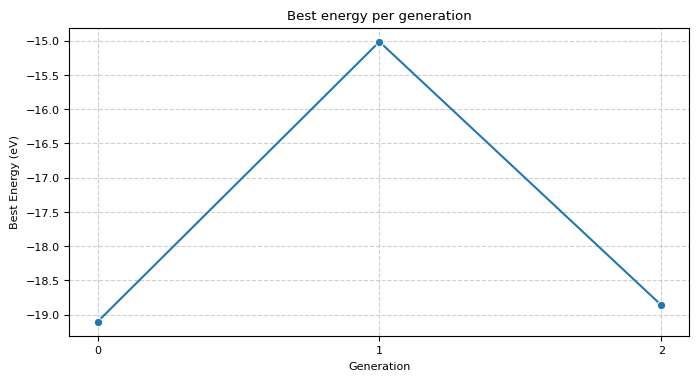

,Results
Initial energy (eV),1589.433392
Final best energy (eV),-18.859414
"Improvement vs initial (ΔE, eV)",1608.292807
Global best energy (eV),-19.102880
Best generation (1-based),1.000000
Generations run,3.000000


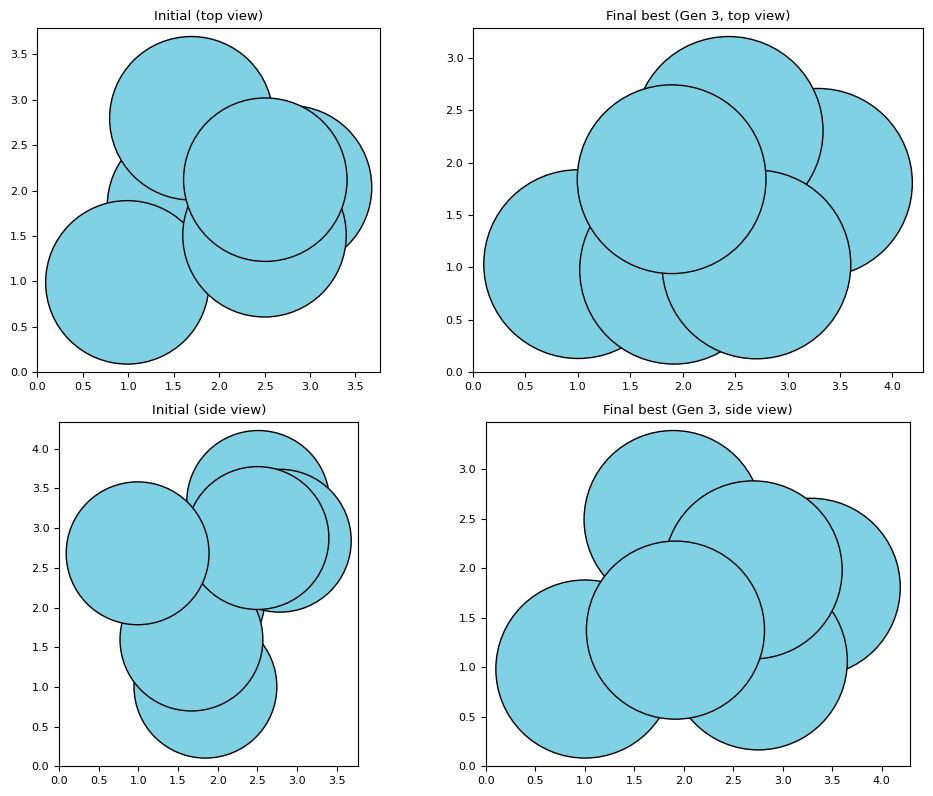

In [9]:
# Analyze output energies and structures
view_results(dst=dst, sort_samples=True, show=False, obj="minimize_eigenval")


In [6]:
from ase.io.jsonio import decode


def analyze_es_energy_groups(h5_filename, run_id=0, obj_params=None, energy_tolerance=0.01, plot=True):
    """
    Analyzes ES results by grouping structures with similar energy levels.
    Calculates actual eigenvalues from structures if obj_params provided, otherwise uses fitness.
    
    Args:
        h5_filename: Path to HDF5 output file from run_evo()
        run_id: Run ID to analyze (default: 0 for first run)
        obj_params: dict with structure parameters (founder_atoms, fixed_atoms, free_atoms, etc.)
                   If provided, actual eigenvalues will be calculated
        energy_tolerance: Energy threshold (in eV) for grouping similar structures
        plot: Whether to plot the results
    
    Returns:
        Dictionary with analysis of energy groups
    """
    with h5py.File(h5_filename, 'r') as f:
        run_group = f[f'run_{run_id}']
        
        all_fitness = []
        best_fitness_per_gen = []
        all_samples = []
        
        # Iterate through generations
        n_gens = len([k for k in run_group.keys() if k.startswith('gen_')])
        
        for gen_idx in range(n_gens):
            gen_group = run_group[f'gen_{gen_idx}']
            fitness = gen_group['fitness'][:]
            samples = gen_group['samples'][:]
            
            # Use negative fitness (actual minimization direction)
            all_fitness.extend(-fitness)
            all_samples.append(samples)
            best_fitness_per_gen.append(-np.max(fitness))  # More negative = lower energy
        
        all_fitness = np.array(all_fitness)
        all_samples = np.concatenate(all_samples, axis=0)
    
    # If obj_params provided, calculate actual eigenvalues from structures
    if obj_params is not None:
        print("Calculating actual eigenvalues from structures...")
        founder_atoms = decode(obj_params["founder_atoms"])
        fixed_atoms = decode(obj_params["fixed_atoms"])
        free_atoms = decode(obj_params["free_atoms"])
        
        frozen_atoms_raw = obj_params.get("frozen_atoms", None)
        frozen_atoms = decode(frozen_atoms_raw) if frozen_atoms_raw is not None else None
        frozen_indices = obj_params.get("frozen_indices", [])
        free_indices = obj_params.get("free_indices")
        
        from util import init_calc, solutions_to_atoms_list, calc_atoms_list, get_lowest_eigenvalue, get_potential_energy
        calc = init_calc(obj_params["calc"], obj_params["device"])
        
        atoms_list = solutions_to_atoms_list(
            solutions=all_samples,
            founder_atoms=founder_atoms,
            fixed_atoms=fixed_atoms,
            fixed_indices=obj_params["fixed_indices"],
            free_atoms=free_atoms,
            calc=calc,
            frozen_atoms=frozen_atoms,
            frozen_indices=frozen_indices,
        )
        
        eigenvalues = calc_atoms_list(
            atoms_list,
            func=get_potential_energy,
            desc="Calculating Eigenvalues",
            multiproc=obj_params["multiproc"],
            n_proc=obj_params["n_proc"],
            progress_bar=obj_params["progress_bar"],
            kwargs={},
        )
        
        all_fitness = np.array(eigenvalues)
    
    # Group structures by similar energy levels
    energy_groups = []
    sorted_indices = np.argsort(all_fitness)  # Sort lowest energy first
    
    for idx in sorted_indices:
        energy = all_fitness[idx]
        
        # Check if this energy belongs to any existing group
        assigned = False
        for group_energy, group_indices in energy_groups:
            if abs(energy - group_energy) < energy_tolerance:
                assigned = True
                group_indices.append(idx)
                break
        
        if not assigned:
            # Create new energy group
            energy_groups.append((energy, [idx]))
    
    print(f"\n{'='*70}")
    print(f"Energy Group Analysis - Run {run_id}")
    print(f"{'='*70}")
    print(f"Total samples evaluated: {len(all_fitness)}")
    print(f"Energy groups found: {len(energy_groups)}")
    print(f"Energy range: {np.min(all_fitness):.6f} to {np.max(all_fitness):.6f} eV")
    print(f"Energy std dev: {np.std(all_fitness):.6f} eV")
    print(f"Energy tolerance: {energy_tolerance} eV")
    print(f"\nEnergy groups (sorted by energy):")
    print(f"{'Rank':<6} {'Energy (eV)':<18} {'Count':<8} {'Frequency':<12}")
    print(f"{'-'*70}")
    
    for rank, (energy, indices) in enumerate(energy_groups, 1):
        count = len(indices)
        frequency = count / len(all_fitness) * 100
        print(f"{rank:<6} {energy:<18.6f} {count:<8} {frequency:>6.2f}%")
    
    print(f"{'='*70}\n")
    
    if plot:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot 1: All energies histogram
        ax = axes[0, 0]
        ax.hist(all_fitness, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel('Energy (eV)')
        ax.set_ylabel('Count')
        ax.set_title('Distribution of All Samples (Eigenvalues)' if obj_params else 'Distribution of All Samples (Fitness)')
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Best energy per generation
        ax = axes[0, 1]
        ax.plot(best_fitness_per_gen, 'o-', color='darkgreen', linewidth=2, markersize=8)
        ax.set_xlabel('Generation')
        ax.set_ylabel('Best Energy (eV)')
        ax.set_title('Convergence: Best Energy per Generation')
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Energy groups
        ax = axes[1, 0]
        group_energies = [e for e, _ in energy_groups]
        group_counts = [len(indices) for _, indices in energy_groups]
        bars = ax.bar(range(len(group_energies)), group_energies, color='coral', edgecolor='black')
        ax.set_xlabel('Energy Group Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title(f'Identified Energy Groups (n={len(energy_groups)})')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add count labels on bars
        for bar, count in zip(bars, group_counts):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'n={count}', ha='center', va='bottom', fontsize=9)
        
        # Plot 4: Energy vs sample index
        ax = axes[1, 1]
        ax.scatter(range(len(all_fitness)), all_fitness, alpha=0.5, s=20, color='navy')
        ax.axhline(np.min(all_fitness), color='red', linestyle='--', label='Best')
        ax.set_xlabel('Sample Index')
        ax.set_ylabel('Energy (eV)')
        ax.set_title('Energy Landscape Across Samples')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'all_energies': all_fitness,
        'best_energy_per_gen': best_fitness_per_gen,
        'energy_groups': energy_groups,
        'n_groups': len(energy_groups),
        'energy_range': (np.min(all_fitness), np.max(all_fitness)),
        'energy_std': np.std(all_fitness),
        'energy_tolerance': energy_tolerance
    }

Calculating actual eigenvalues from structures...


python(42813) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42814) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42817) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42818) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(42819) Malloc

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
cuequivariance or cuequivariance_torch is not available. Cuequivariance a

Calculating Eigenvalues: 100%|██████████| 160/160 [00:36<00:00,  4.40it/s]



Energy Group Analysis - Run 0
Total samples evaluated: 160
Energy groups found: 31
Energy range: -15.444734 to -0.001522 eV
Energy std dev: 2.654454 eV
Energy tolerance: 0.01 eV

Energy groups (sorted by energy):
Rank   Energy (eV)        Count    Frequency   
----------------------------------------------------------------------
1      -15.444734         16        10.00%
2      -15.319864         5          3.12%
3      -15.283421         25        15.62%
4      -15.058869         1          0.62%
5      -15.033384         7          4.38%
6      -14.977197         1          0.62%
7      -14.816400         1          0.62%
8      -14.596946         21        13.12%
9      -14.568061         2          1.25%
10     -14.548573         3          1.88%
11     -13.837989         1          0.62%
12     -13.637286         2          1.25%
13     -13.615800         1          0.62%
14     -13.589122         1          0.62%
15     -13.505235         1          0.62%
16     -13.486879     

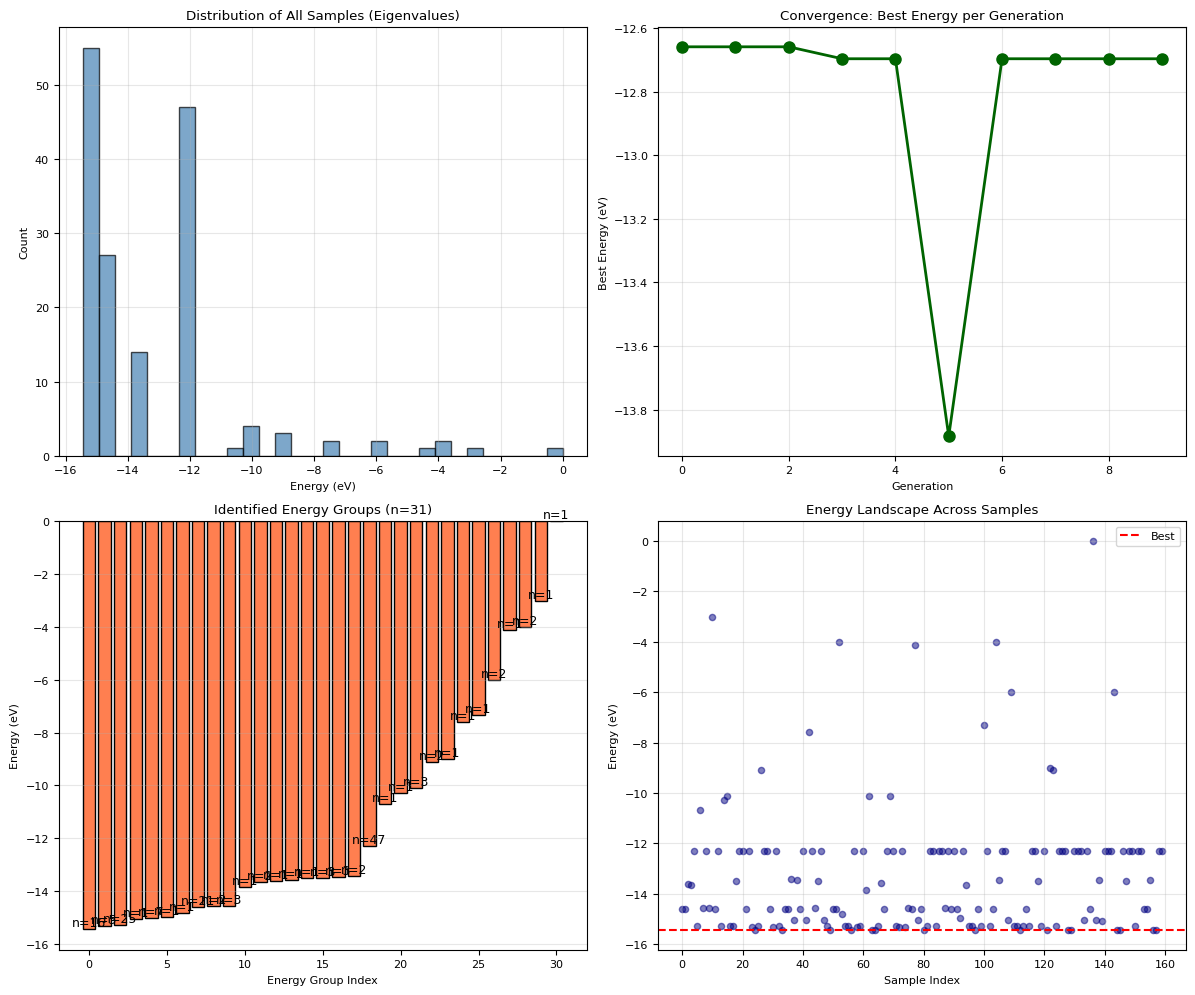

In [7]:
# Analyze ES convergence and minima found
h5_file = evo[0]  # First element of evo tuple is the h5_filename
run_id = evo[1]   # Second element is the run_id

convergence_analysis = analyze_es_energy_groups(
    h5_file, 
    run_id=run_id, 
    obj_params=ts_optimizer.encode_params(),
    plot=True
)